# Breakout

In [1]:
import sys
import copy

import torch
import gymnasium as gym
import matplotlib.pyplot as plt

sys.path.append("../")
from breakout.DQN import VisionDeepQ

In [2]:
environment = gym.make('ALE/Breakout-v5', render_mode="rgb_array",
                       obs_type="grayscale", frameskip=1, repeat_action_probability=0.0)
environment.metadata["render_fps"] = 30

GAMES = 10
SKIP = 6

SHAPE = {
    "original": (1, 1, 210, 160),
    "height": slice(31, -17),
    "width": slice(7, -7),
}

DISCOUNT = 0.95
GAMMA = 0.99
GRADIENTS = (-1, 1)

PUNISHMENT = 0
INCENTIVE = 1

MINIBATCH = 32
TRAIN_EVERY = 25

EXPLORATION_RATE = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_STEPS = 45000 // TRAIN_EVERY

MIN_REWARD = lambda game: 0#game / 500 if game <= 5000 else 10
MEMORY = 1500
RESET_Q_EVERY = TRAIN_EVERY * 5

NETWORK = {
    "input_channels": 1, "outputs": 4,
    "channels": [32, 64, 64],
    "kernels": [8, 4, 3],
    "padding": ["valid", "valid", "valid"],
    "strides": [4, 2, 1],
    "nodes": [512],
}
OPTIMIZER = {
    "optimizer": torch.optim.RMSprop,
    "lr": 0.00025,
    "hyperparameters": {"eps": 1e-6, "weight_decay": 0.99}
}

breakout = VisionDeepQ(
    network=NETWORK, optimizer=OPTIMIZER, shape=SHAPE,

    batch_size=MINIBATCH, memory=MEMORY,

    discount=DISCOUNT, gamma=GAMMA,
    punishment=PUNISHMENT, incentive=INCENTIVE,

    exploration_rate=EXPLORATION_RATE,
    exploration_steps=EXPLORATION_STEPS,
    exploration_min=EXPLORATION_MIN,
)
_value_agent = copy.deepcopy(breakout)

TRAINING = False
_STEPS = _LOSS = _REWARD = 0
for game in range(1, GAMES + 1):
    initial = breakout.preprocess(environment.reset()[0])
    states = torch.cat([initial] * breakout.shape["reshape"][1], dim=1)

    DONE = False
    STEPS = REWARDS = 0
    TRAINING = True if (not TRAINING and len(breakout.memory["memory"]) > 0) else TRAINING
    while not DONE:
        action, new_states, rewards, DONE = breakout.observe(environment, states, SKIP)
        breakout.remember(states, action, torch.tensor(rewards))

        states = new_states
        REWARDS += rewards
        STEPS += 1

    if REWARDS >= MIN_REWARD(game):
        breakout.memorize(states, STEPS)
    breakout.memory["game"].clear()

    LOSS = None
    if game % TRAIN_EVERY == 0 and TRAINING:
        LOSS = breakout.learn(network=_value_agent, clamp=GRADIENTS)
        EXPLORATION_RATE = breakout.parameter["rate"]
        _LOSS += LOSS
    _REWARD += REWARDS
    _STEPS += STEPS

    if game % RESET_Q_EVERY == 0 and TRAINING:
        _value_agent.load_state_dict(breakout.state_dict())

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
memory = breakout.memory["memory"]

_steps = [game.steps for game in memory]
steps = [sum(_steps[:i + 1]) - 1 for i in range(len(_steps))]

states = torch.cat([torch.stack(game.state).squeeze(1) for game in memory])
actions = torch.cat([torch.stack(game.action) for game in memory])
_states = torch.cat([game.new_state for game in memory])
rewards = torch.cat([torch.stack(game.reward).detach() for game in memory])

print(states.shape, actions.shape, _states.shape, rewards.shape)

_reward = 0
for i in reversed(range(len(rewards))):
    _reward = breakout.parameter["punishment"] if i in steps else _reward
    _reward = (_reward * breakout.parameter["discount"]
               + rewards[i] * breakout.parameter["incentive"])
    rewards[i] = _reward

rewards = ((rewards - rewards.mean()) / (rewards.std() + 1e-9)).view(-1, 1)

print(rewards.shape)

with torch.cuda.amp.autocast():
    actual = breakout(states).gather(1, actions)

    with torch.no_grad():
        new_states = torch.roll(states, -1, 0)
        new_states[torch.tensor(steps)] = _states

        optimal = breakout.parameter["gamma"] * _value_agent(new_states).max(1)[0].unsqueeze(1)
        optimal = rewards + optimal

    for step in steps:
        optimal[step] = rewards[step]
        
print(actual.shape, optimal.shape)

torch.Size([1376, 1, 80, 80]) torch.Size([1376, 1]) torch.Size([10, 1, 80, 80]) torch.Size([1376])
torch.Size([1376, 1])


/Users/Mac/anaconda3/envs/spesialpensum/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([1376, 1]) torch.Size([1376, 1])


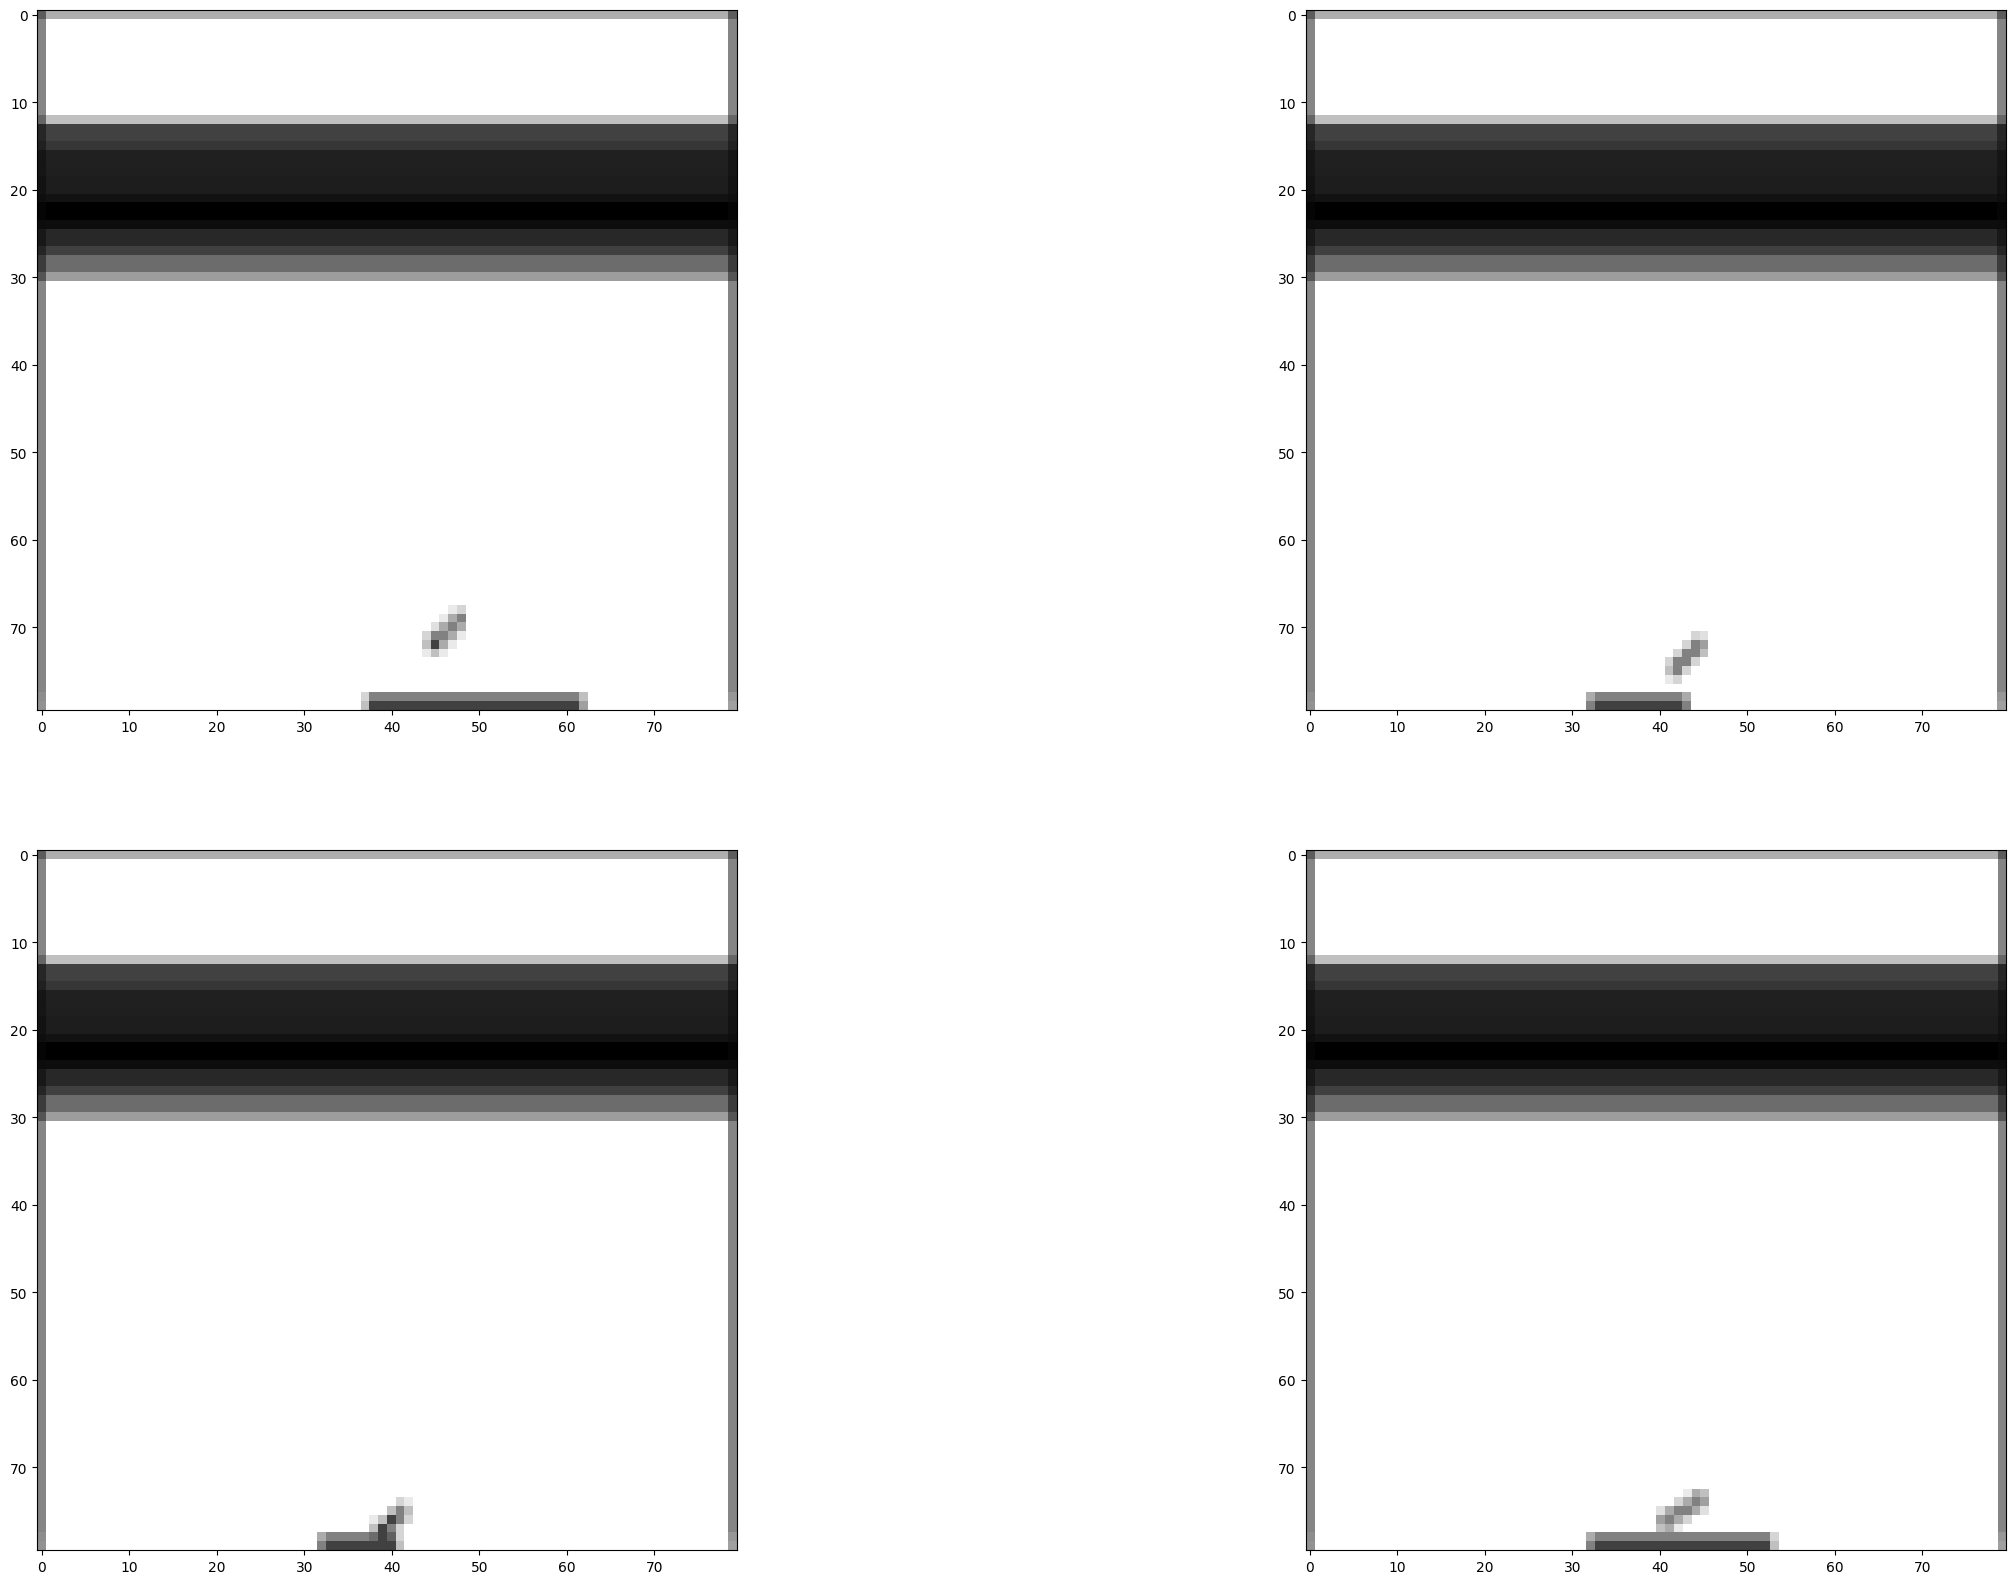

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(30, 20))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(states[10 + i, 0], cmap="binary")

# Tetris

In [5]:
import sys

import torch
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import colors

sys.path.append("../")
from tetris.DQN import VisionDeepQ

In [6]:
environment = gym.make('ALE/Tetris-v5', render_mode="rgb_array",
                       obs_type="grayscale", frameskip=1, repeat_action_probability=0.0)
environment.metadata["render_fps"] = 30

GAMES = 10
SKIP = 3

SHAPE = {
    "original": (1, 1, 210, 160),
    "height": slice(27, 203),
    "width": slice(22, 64)
}

DISCOUNT = 0.95
GAMMA = 0.99
GRADIENTS = (-1, 1)

PUNISHMENT = -5
INCENTIVE = 1

MINIBATCH = 64
TRAIN_EVERY = 1
START_TRAINING_AT = 64

EXPLORATION_RATE = 1.0
EXPLORATION_MIN = 0.001
EXPLORATION_STEPS = 5000 // TRAIN_EVERY

MEMORY = 500

NETWORK = {
    "input_channels": 4, "outputs": 5,
    "channels": [128, 64],
    "kernels": [2, 2],
    "padding": ["valid", "valid"],
    "strides": [2, 1],
    "nodes": [128],
}
OPTIMIZER = {
    "optimizer": torch.optim.RMSprop,
    "lr": 0.0001,
    "hyperparameters": {}
}

tetris = VisionDeepQ(
    network=NETWORK, optimizer=OPTIMIZER, shape=SHAPE,

    batch_size=MINIBATCH, memory=MEMORY,

    discount=DISCOUNT, gamma=GAMMA,
    punishment=PUNISHMENT, incentive=INCENTIVE,

    exploration_rate=EXPLORATION_RATE,
    exploration_steps=EXPLORATION_STEPS,
    exploration_min=EXPLORATION_MIN,
)

TRAINING = False
_STEPS = _LOSS = _REWARD = 0
for game in range(1, GAMES + 1):
    initial = tetris.preprocess(environment.reset()[0])
    states = torch.cat(
        [initial.view(1, 1, *tetris.shape["reshape"][2:])] * tetris.shape["reshape"][1],
        dim=1
    )

    DONE = False
    STEPS = REWARDS = 0
    TRAINING = True if (not TRAINING and len(tetris.memory["memory"]) > START_TRAINING_AT) else TRAINING
    while not DONE:
        action, new_states, rewards, DONE = tetris.observe(environment, states, SKIP)
        tetris.remember(states, action, torch.tensor(rewards))

        states = new_states
        REWARDS += rewards
        STEPS += 1

    tetris.memorize(states, STEPS)
    tetris.memory["game"].clear()

In [7]:
memory = tetris.memory["memory"]

_steps = [game.steps for game in memory]
steps = [sum(_steps[:i + 1]) - 1 for i in range(len(_steps))]

states = torch.cat([torch.stack(game.state).squeeze(1) for game in memory])
actions = torch.cat([torch.stack(game.action) for game in memory])
_states = torch.cat([game.new_state for game in memory])
rewards = torch.cat([torch.stack(game.reward).detach() for game in memory])

print(states.shape, actions.shape, _states.shape, rewards.shape)

_reward = 0
for i in reversed(range(len(rewards))):
    _reward = tetris.parameter["punishment"] if i in steps else _reward
    _reward = (_reward * tetris.parameter["discount"]
               + rewards[i] * tetris.parameter["incentive"])
    rewards[i] = _reward

rewards = ((rewards - rewards.mean()) / (rewards.std() + 1e-9)).view(-1, 1)

print(rewards.shape)

with torch.cuda.amp.autocast():
    actual = tetris(states).gather(1, actions)

    with torch.no_grad():
        new_states = torch.roll(states, -1, 0)
        new_states[torch.tensor(steps)] = _states

        optimal = tetris.parameter["gamma"] * tetris(new_states).max(1)[0].unsqueeze(1)
        optimal = rewards + optimal

    for step in steps:
        optimal[step] = rewards[step]
        
print(actual.shape, optimal.shape)

torch.Size([1945, 4, 22, 10]) torch.Size([1945, 1]) torch.Size([10, 4, 22, 10]) torch.Size([1945])
torch.Size([1945, 1])
torch.Size([1945, 1]) torch.Size([1945, 1])


In [8]:
initial = tetris.preprocess(environment.reset()[0])
built = (initial == 0.0).all(1).nonzero()[-1].item()
built

21

torch.Size([1, 4, 22, 10])


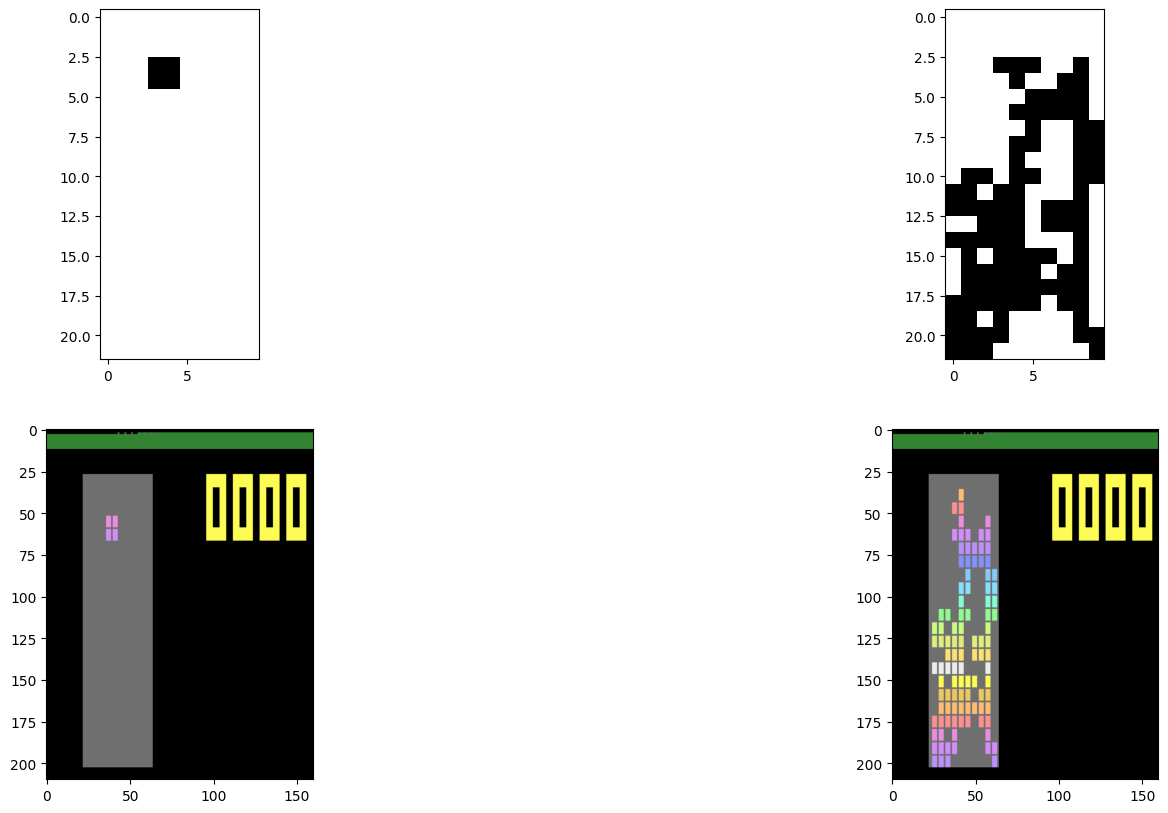

In [9]:
initial = tetris.preprocess(environment.reset()[0])
states = torch.cat(
    [initial.view(1, 1, *tetris.shape["reshape"][2:])] * tetris.shape["reshape"][1],
    dim=1
)

print(states.shape)

def observe(skip=1):
    action = environment.action_space.sample()

    done = False
    states = torch.zeros(tetris.shape["reshape"])

    for i in range(0, tetris.shape["reshape"][1]):
        for _ in range(skip):
            new_state, reward, terminated, truncated, _ = environment.step(action)
            new_state = tetris.preprocess(new_state)
            
            if new_state[0:5, 3:7].any():
                tetris.parameter["new"] = True

            done = (terminated or truncated) if not done else done

        states[0, i] = new_state

    return states, done

DONE = False
observed = {"raw": [states], "render": [environment.render()]}
while not DONE:
    states, DONE = observe(SKIP)
    
    observed["raw"].append(states)
    observed["render"].append(environment.render())
    
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].imshow(observed["raw"][0][0,0], cmap="binary")
axs[1].imshow(observed["raw"][-1][0,0], cmap="binary")
axs[2].imshow(observed["render"][0])
axs[3].imshow(observed["render"][-1])

Text(0.5, 1.0, '3 holes')

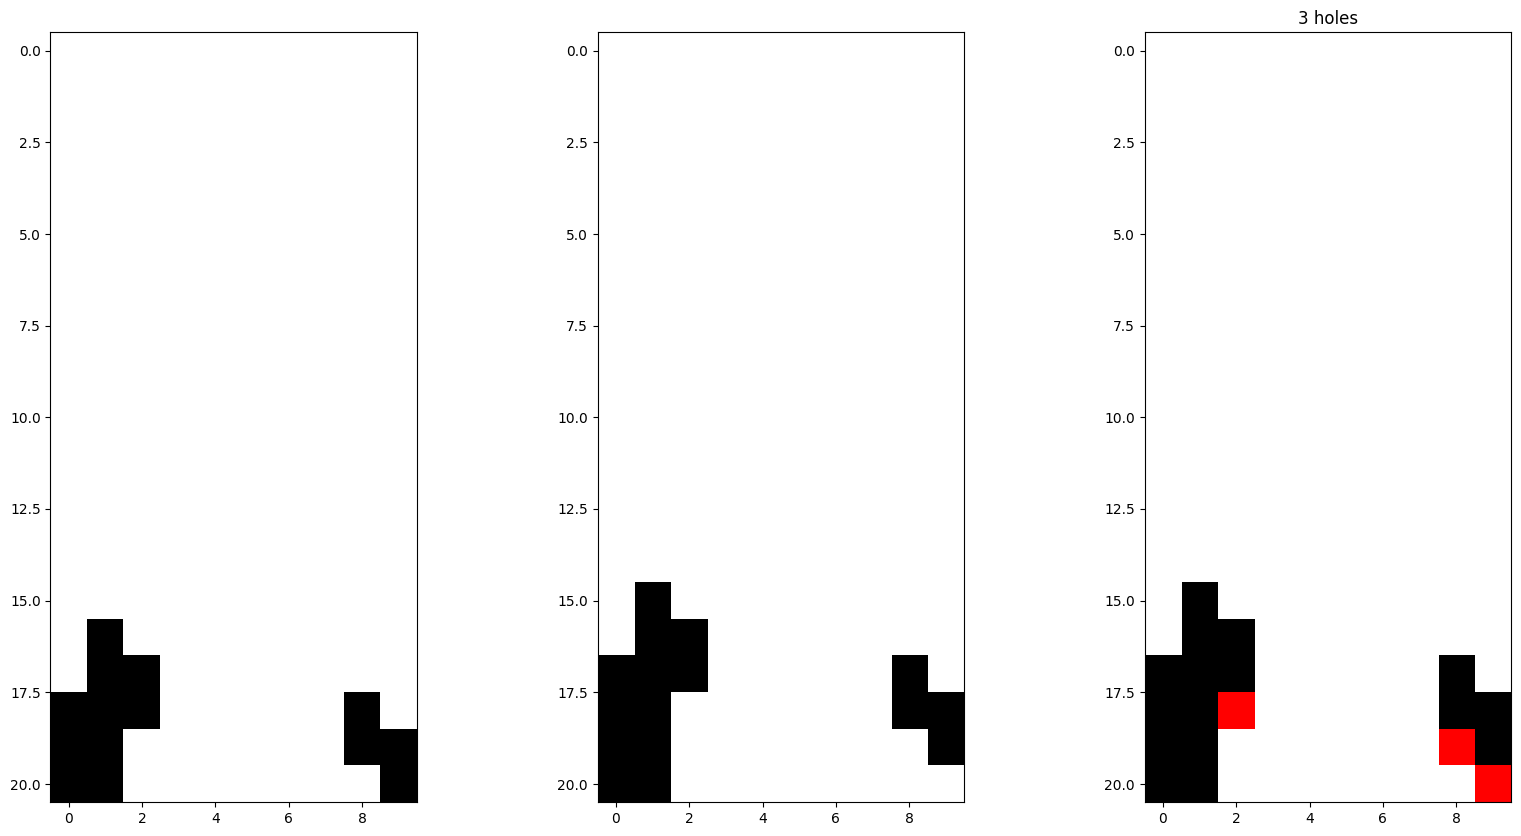

In [10]:
current = observed["raw"][50][0, 0]

above = torch.roll(current, 1, 0)[1:, :].clone()
below = current[1:, :].clone()

diff = below * 2 - above

holes = sum(diff.flatten() == -1).item()

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(above, cmap="binary")
axs[1].imshow(below, cmap="binary")

cmap = colors.ListedColormap(['red', 'white', 'black', 'black'])
bounds = [-1, 0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

axs[2].imshow(diff, cmap=cmap, norm=norm)
axs[2].set_title(f"{holes} holes")

In [11]:
current.shape[0] - (current == 0.0).all(1).nonzero()[-1].item()

7